Build a classifier for Street View House Numbers (SVHN) (Dataset) using pretrained model weights from PyTorch. Try multiple
models like LeNet-5, AlexNet, VGG, or ResNet(18, 50, 101). Compare performance comment why a particular model is well suited
for SVHN dataset. (You can use a subset of dataset (25%) in case you do not have enough compute.)

Note to self: Importing and making DataLoaders will take time.

# Imports go here

In [1]:
import torch
import torch.nn as nn
from torchvision.datasets.svhn import SVHN
from torchvision.utils import make_grid
from torchvision.transforms import ToTensor, transforms
from torch.utils.data.dataloader import DataLoader

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import time

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from torchsummary import summary

# Necessary Functions

## Function for loading the dataset based on the necessary transformation needed by the model

In [4]:
def load_data(transformation, model_name):
    svhn_train = SVHN(root='./DSE316', split='train',
                      download=True, transform=transformation)
    svhn_test = SVHN(root='./DSE316', split='test',
                     download=True, transform=transformation)

    t_split, v_split = train_test_split(
        svhn_train, test_size=0.25, random_state=2)

    train_loader = DataLoader(t_split, batch_size=32)
    val_loader = DataLoader(v_split, batch_size=32)
    test_loader = DataLoader(svhn_test, batch_size=32)

    return train_loader, val_loader, test_loader

## Function for visualizing a DataLoader to see if it has been made properly

In [5]:
def visualize(loader):
    for images, _ in loader:
        print('Shape:', images.shape)
        plt.figure(figsize=(16, 8))
        plt.axis('off')
        plt.imshow(make_grid(images, nrow=16).permute(1, 2, 0))
        plt.show()
        break

## Function for plotting curves

In [26]:
def plot_curves(train, val, kind):
    plt.figure()
    plt.plot(train, label=f'Train {kind}')
    plt.plot(val, label=f'Val {kind}')
    plt.xlabel('Epochs')
    plt.ylabel(kind)
    plt.legend()
    plt.show()

## Function to facilitate the training

In [18]:
def train_model(model, model_name, train_loader, val_loader):
    cost = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    epochs = 10
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    print('Current Device:', device)

    train_losses = []
    train_accs = []
    val_losses = []
    val_accs = []

    print('*'*80)
    print(f'Now Training:: {model_name}')
    print('*'*80)

    for epoch in range(epochs):

        # Training
        model.train()
        tot_train_loss = 0
        train_correct = 0
        train_tot = 0

        tick = time.time()

        for batch_id, (imgs, labels) in enumerate(train_loader):
            # Sending the data to the device
            imgs = imgs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            # Fwd Pass
            out = model(imgs)
            loss = cost(out, labels)

            # Bwd Pass
            loss.backward()
            optimizer.step()

            tot_train_loss += loss.item()*imgs.size(0)

            x, pred = torch.max(out, 1)
            train_correct += (pred == labels).sum().item()
            train_tot += labels.size(0)

        train_loss = tot_train_loss/len(train_loader.dataset)
        train_acc = train_correct/train_tot
        train_losses.append(train_loss)
        train_accs.append(train_acc)

        # Validation
        model.eval()
        tot_val_loss = 0
        val_correct = 0
        val_tot = 0

        with torch.no_grad():
            for val_imgs, val_labels in val_loader:
                val_imgs = val_imgs.to(device)
                val_labels = val_labels.to(device)

                val_out = model(val_imgs)
                vloss = cost(val_out, val_labels)
                tot_val_loss += vloss.item()*val_imgs.size(0)

                _, val_pred = torch.max(val_out, 1)
                val_correct += (val_pred == val_labels).sum().item()
                val_tot += val_labels.size(0)

        val_loss = tot_val_loss/len(val_loader.dataset)
        val_acc = val_correct/val_tot
        val_losses.append(val_loss)
        val_accs.append(val_acc)

        tock = time.time()
        tot_time = tock-tick

        print(f'Epoch:{epoch+1}\t Train_Loss: {train_loss:.4f}\t Val_Loss: {val_loss:.4f}\t Train_Acc: {train_acc:.4f}\t Val_Acc: {val_acc:.4f}\t Time: {tot_time:.2f} seconds')

    plot_curves(train_accs, val_accs, kind='Accuracy')
    plot_curves(train_losses, val_losses, kind='Loss')

    return model

## Function to facilitate the evaluation

In [12]:
def evaluate_model(model, model_name, test_loader):

    model.eval()
    all_labels = []
    preds = []
    labels = [test_loader.dataset[i][1] for i in range(len(test_loader))]
    # print(test_loader.dataset[0])
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print('Current Device:', device)

    with torch.no_grad():
        for imgs, labels in test_loader:
            imgs = imgs.to(device)
            labels = labels.to(device)
            out = model(imgs)
            _, pred = torch.max(out, 1)

            all_labels.extend(labels.cpu().numpy())
            preds.extend(pred.cpu().numpy())

    print('Classification Report:')
    print(classification_report(all_labels, preds, target_names=[str(i) for i in range(10)]))

    print('Confusion Matrix:')
    cm = confusion_matrix(all_labels, preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[str(i) for i in range(10)])
    disp.plot()
    plt.tight_layout()
    disp.ax_.set_xticklabels(labels=[str(i) for i in range(10)], rotation=90)
    plt.show()

# Model Evaluation

## LeNet-5

Works on 32x32x1 input

### LeNet-5 implementation

In [27]:
import torch.nn.functional as F


class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16*5*5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        x = F.max_pool2d(F.relu(self.conv2(x)), (2, 2))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = (self.fc3(x))
        return x

In [28]:
model_lenet = LeNet()

In [29]:
summary(model_lenet.cuda(), input_size=(1,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 28, 28]             156
            Conv2d-2           [-1, 16, 10, 10]           2,416
            Linear-3                  [-1, 120]          48,120
            Linear-4                   [-1, 84]          10,164
            Linear-5                   [-1, 10]             850
Total params: 61,706
Trainable params: 61,706
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.05
Params size (MB): 0.24
Estimated Total Size (MB): 0.29
----------------------------------------------------------------


### Loading, Training and Testing

In [15]:
LeNet_transformer = transforms.Compose([
    transforms.Grayscale(),
    transforms.ToTensor()
])
LeNet_train_loader, LeNet_val_loader, LeNet_test_loader = load_data(
    LeNet_transformer, 'LeNet-5')

100%|██████████| 182040794/182040794 [00:10<00:00, 16750192.58it/s]


100%|██████████| 64275384/64275384 [00:02<00:00, 30923047.67it/s]


Shape: torch.Size([32, 1, 32, 32])


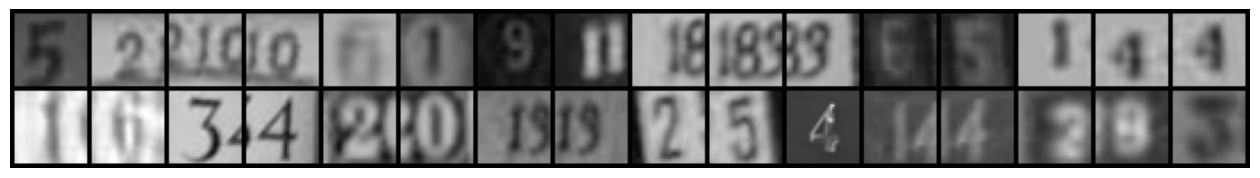

In [24]:
visualize(LeNet_test_loader)

Current Device: cuda
********************************************************************************
Now Training:: LeNet-5
********************************************************************************
Epoch:1	 Train_Loss: 1.4142	 Val_Loss: 0.7920	 Train_Acc: 0.5223	 Val_Acc: 0.7610	 Time: 5.39 seconds
Epoch:2	 Train_Loss: 0.6556	 Val_Loss: 0.5811	 Train_Acc: 0.8039	 Val_Acc: 0.8255	 Time: 5.05 seconds
Epoch:3	 Train_Loss: 0.5322	 Val_Loss: 0.5260	 Train_Acc: 0.8407	 Val_Acc: 0.8397	 Time: 5.21 seconds
Epoch:4	 Train_Loss: 0.4751	 Val_Loss: 0.4886	 Train_Acc: 0.8579	 Val_Acc: 0.8518	 Time: 5.19 seconds
Epoch:5	 Train_Loss: 0.4356	 Val_Loss: 0.4665	 Train_Acc: 0.8696	 Val_Acc: 0.8585	 Time: 4.98 seconds
Epoch:6	 Train_Loss: 0.4057	 Val_Loss: 0.4527	 Train_Acc: 0.8785	 Val_Acc: 0.8627	 Time: 5.39 seconds
Epoch:7	 Train_Loss: 0.3820	 Val_Loss: 0.4484	 Train_Acc: 0.8861	 Val_Acc: 0.8652	 Time: 4.96 seconds
Epoch:8	 Train_Loss: 0.3629	 Val_Loss: 0.4425	 Train_Acc: 0.8917	 Val_Acc: 0.867

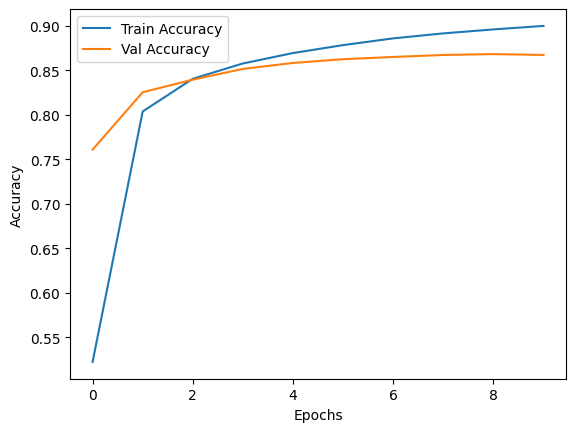

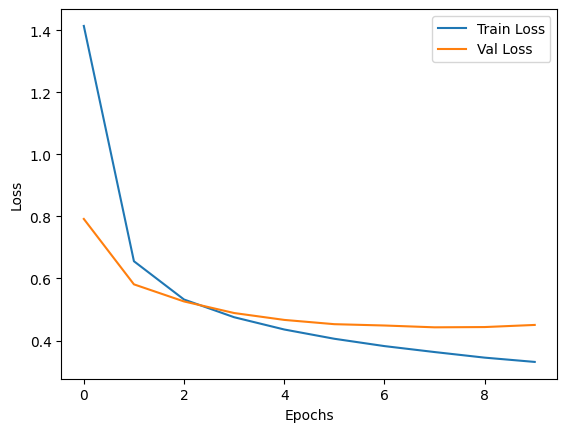

In [30]:
model_lenet = train_model(model_lenet, 'LeNet-5',
                          LeNet_train_loader, LeNet_val_loader)

Current Device: cuda
Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.86      0.84      1744
           1       0.91      0.90      0.91      5099
           2       0.90      0.90      0.90      4149
           3       0.76      0.84      0.80      2882
           4       0.87      0.84      0.86      2523
           5       0.88      0.83      0.86      2384
           6       0.85      0.78      0.81      1977
           7       0.84      0.89      0.86      2019
           8       0.80      0.80      0.80      1660
           9       0.79      0.80      0.80      1595

    accuracy                           0.86     26032
   macro avg       0.84      0.84      0.84     26032
weighted avg       0.86      0.86      0.86     26032

Confusion Matrix:


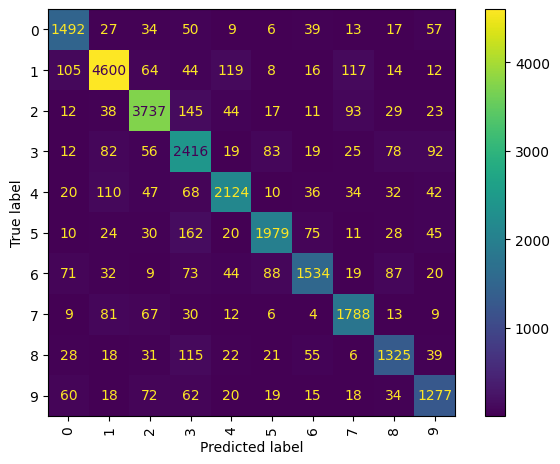

In [31]:
evaluate_model(model_lenet, 'LeNet-5', LeNet_test_loader)

## AlexNet

Works on a minimum 3x63x63 input

### Initializing the model

In [32]:
from torchvision.models import AlexNet, AlexNet_Weights, alexnet

In [33]:
model_alex = alexnet(weights=AlexNet_Weights)
# print(model)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:04<00:00, 49.2MB/s]


In [34]:
for param in model_alex.parameters():
    param.requires_grad = False

In [35]:
model_alex.classifier[6] = nn.Linear(
    in_features=4096, out_features=10)

In [36]:
summary(model_alex.cuda(), input_size=(3,63,63))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 15, 15]          23,296
              ReLU-2           [-1, 64, 15, 15]               0
         MaxPool2d-3             [-1, 64, 7, 7]               0
            Conv2d-4            [-1, 192, 7, 7]         307,392
              ReLU-5            [-1, 192, 7, 7]               0
         MaxPool2d-6            [-1, 192, 3, 3]               0
            Conv2d-7            [-1, 384, 3, 3]         663,936
              ReLU-8            [-1, 384, 3, 3]               0
            Conv2d-9            [-1, 256, 3, 3]         884,992
             ReLU-10            [-1, 256, 3, 3]               0
           Conv2d-11            [-1, 256, 3, 3]         590,080
             ReLU-12            [-1, 256, 3, 3]               0
        MaxPool2d-13            [-1, 256, 1, 1]               0
AdaptiveAvgPool2d-14            [-1, 25

### Loading the data and training

In [37]:
AlexNet_transformer = transforms.Compose([
    transforms.Resize(size=((63, 63))),
    transforms.ToTensor()
])
AlexNet_train_loader, AlexNet_val_loader, AlexNet_test_loader = load_data(
    AlexNet_transformer, 'AlexNet-5')

Using downloaded and verified file: ./DSE316/train_32x32.mat
Using downloaded and verified file: ./DSE316/test_32x32.mat


Shape: torch.Size([32, 3, 63, 63])


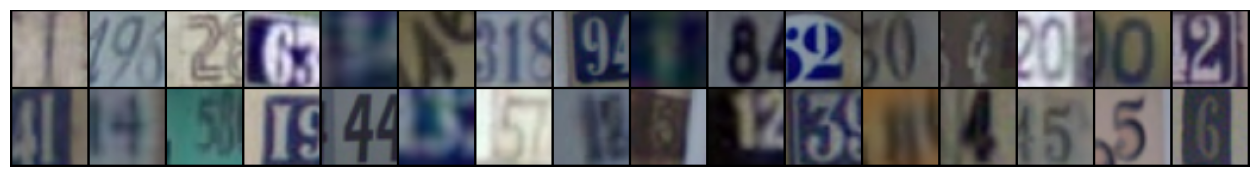

In [39]:
visualize(AlexNet_val_loader)

Current Device: cuda
********************************************************************************
Now Training:: AlexNet
********************************************************************************
Epoch:1	 Train_Loss: 1.8048	 Val_Loss: 1.6055	 Train_Acc: 0.4031	 Val_Acc: 0.4405	 Time: 8.64 seconds
Epoch:2	 Train_Loss: 1.7562	 Val_Loss: 1.5526	 Train_Acc: 0.4246	 Val_Acc: 0.4650	 Time: 8.59 seconds
Epoch:3	 Train_Loss: 1.7577	 Val_Loss: 1.5823	 Train_Acc: 0.4285	 Val_Acc: 0.4576	 Time: 8.60 seconds
Epoch:4	 Train_Loss: 1.7537	 Val_Loss: 1.5114	 Train_Acc: 0.4334	 Val_Acc: 0.4817	 Time: 8.52 seconds
Epoch:5	 Train_Loss: 1.7427	 Val_Loss: 1.5503	 Train_Acc: 0.4368	 Val_Acc: 0.4662	 Time: 8.68 seconds
Epoch:6	 Train_Loss: 1.7523	 Val_Loss: 1.5559	 Train_Acc: 0.4344	 Val_Acc: 0.4683	 Time: 8.68 seconds
Epoch:7	 Train_Loss: 1.7514	 Val_Loss: 1.5450	 Train_Acc: 0.4347	 Val_Acc: 0.4716	 Time: 8.63 seconds
Epoch:8	 Train_Loss: 1.7515	 Val_Loss: 1.5959	 Train_Acc: 0.4362	 Val_Acc: 0.451

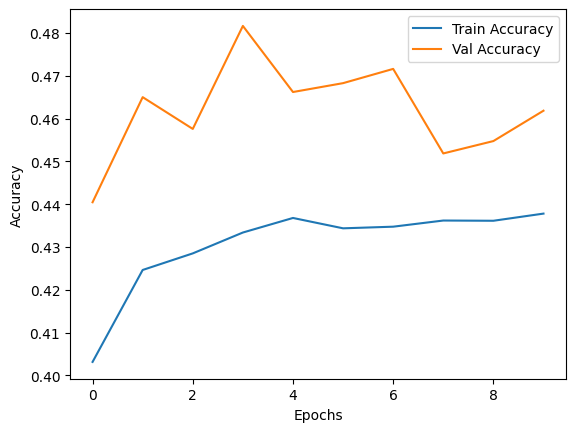

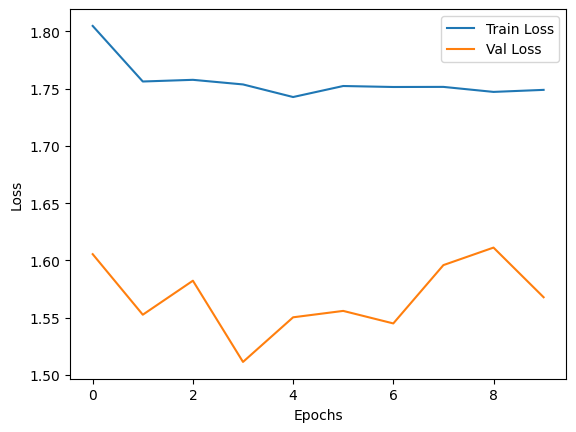

In [38]:
model_alex = train_model(model_alex, 'AlexNet',
                         AlexNet_train_loader, AlexNet_val_loader)

Current Device: cuda
Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.42      0.55      1744
           1       0.86      0.56      0.68      5099
           2       0.45      0.46      0.46      4149
           3       0.29      0.23      0.26      2882
           4       0.60      0.35      0.44      2523
           5       0.26      0.74      0.39      2384
           6       0.38      0.31      0.34      1977
           7       0.67      0.36      0.47      2019
           8       0.17      0.33      0.22      1660
           9       0.40      0.23      0.29      1595

    accuracy                           0.43     26032
   macro avg       0.49      0.40      0.41     26032
weighted avg       0.52      0.43      0.44     26032

Confusion Matrix:


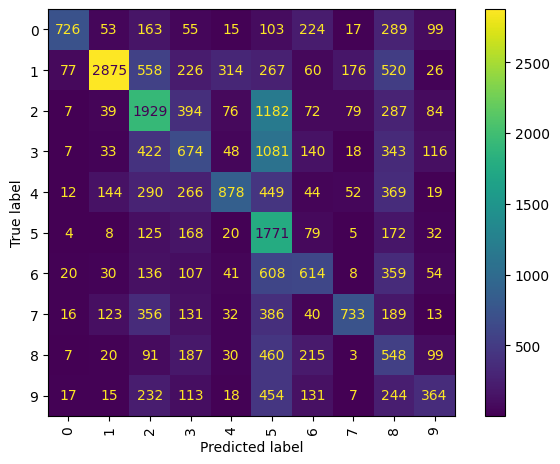

In [40]:
evaluate_model(model_alex, 'AlexNet', AlexNet_test_loader)

## VGG

Works on minimum 3x32x32 input

### Initializing the model

In [41]:
from torchvision.models import vgg16, VGG16_Weights

In [42]:
model_vgg = vgg16(weights=VGG16_Weights)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:18<00:00, 30.5MB/s]


In [43]:
# print(model_vgg)
for param in model_vgg.parameters():
    param.requires_grad = False

In [44]:
model_vgg.classifier[6] = nn.Linear(
    in_features=4096, out_features=10)

In [45]:
summary(model_vgg.cuda(), input_size=(3,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,792
              ReLU-2           [-1, 64, 32, 32]               0
            Conv2d-3           [-1, 64, 32, 32]          36,928
              ReLU-4           [-1, 64, 32, 32]               0
         MaxPool2d-5           [-1, 64, 16, 16]               0
            Conv2d-6          [-1, 128, 16, 16]          73,856
              ReLU-7          [-1, 128, 16, 16]               0
            Conv2d-8          [-1, 128, 16, 16]         147,584
              ReLU-9          [-1, 128, 16, 16]               0
        MaxPool2d-10            [-1, 128, 8, 8]               0
           Conv2d-11            [-1, 256, 8, 8]         295,168
             ReLU-12            [-1, 256, 8, 8]               0
           Conv2d-13            [-1, 256, 8, 8]         590,080
             ReLU-14            [-1, 25

### Loading, Training and Testing

In [46]:
VGG_transformer = transforms.Compose([
    transforms.ToTensor()
])
VGG_train_loader, VGG_val_loader, VGG_test_loader = load_data(
    VGG_transformer, 'VGG-16')

Using downloaded and verified file: ./DSE316/train_32x32.mat
Using downloaded and verified file: ./DSE316/test_32x32.mat


Shape: torch.Size([32, 3, 32, 32])


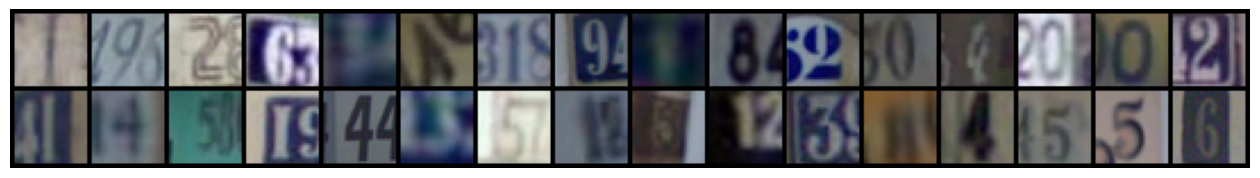

In [47]:
visualize(VGG_val_loader)

Current Device: cuda
********************************************************************************
Now Training:: VGG-16
********************************************************************************
Epoch:1	 Train_Loss: 2.0815	 Val_Loss: 1.7109	 Train_Acc: 0.3293	 Val_Acc: 0.4055	 Time: 23.93 seconds
Epoch:2	 Train_Loss: 2.1000	 Val_Loss: 1.6871	 Train_Acc: 0.3382	 Val_Acc: 0.4176	 Time: 23.96 seconds
Epoch:3	 Train_Loss: 2.1047	 Val_Loss: 1.6935	 Train_Acc: 0.3408	 Val_Acc: 0.4207	 Time: 24.52 seconds
Epoch:4	 Train_Loss: 2.1057	 Val_Loss: 1.7015	 Train_Acc: 0.3427	 Val_Acc: 0.4099	 Time: 24.13 seconds
Epoch:5	 Train_Loss: 2.1041	 Val_Loss: 1.7118	 Train_Acc: 0.3407	 Val_Acc: 0.4021	 Time: 24.08 seconds
Epoch:6	 Train_Loss: 2.1051	 Val_Loss: 1.6879	 Train_Acc: 0.3425	 Val_Acc: 0.4204	 Time: 24.20 seconds
Epoch:7	 Train_Loss: 2.1166	 Val_Loss: 1.6893	 Train_Acc: 0.3382	 Val_Acc: 0.4073	 Time: 24.18 seconds
Epoch:8	 Train_Loss: 2.0988	 Val_Loss: 1.7124	 Train_Acc: 0.3453	 Val_Acc:

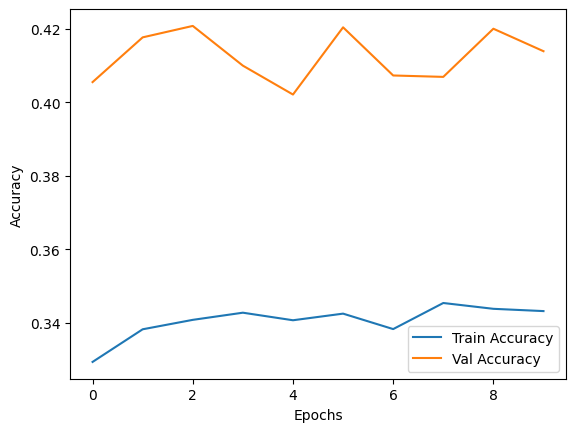

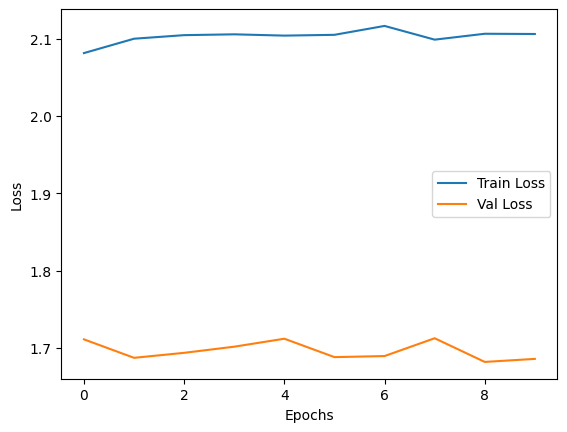

In [48]:
model_vgg = train_model(model_vgg, 'VGG-16', VGG_train_loader, VGG_val_loader)

Current Device: cuda
Classification Report:
              precision    recall  f1-score   support

           0       0.44      0.38      0.41      1744
           1       0.65      0.61      0.63      5099
           2       0.41      0.56      0.47      4149
           3       0.28      0.16      0.20      2882
           4       0.43      0.41      0.42      2523
           5       0.35      0.30      0.32      2384
           6       0.29      0.47      0.36      1977
           7       0.39      0.48      0.43      2019
           8       0.28      0.32      0.30      1660
           9       0.41      0.11      0.18      1595

    accuracy                           0.42     26032
   macro avg       0.39      0.38      0.37     26032
weighted avg       0.42      0.42      0.41     26032

Confusion Matrix:


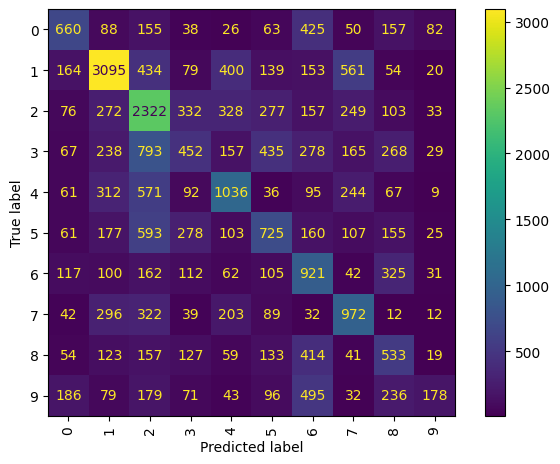

In [49]:
evaluate_model(model_vgg, 'VGG-16', VGG_test_loader)

## ResNet-18

Works on a minimum 1x1 input

### Initializing the model

In [50]:
from torchvision.models import ResNet18_Weights, resnet18

In [51]:
model_res = resnet18(weights=ResNet18_Weights)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 134MB/s]


In [52]:
for param in model_res.parameters():
    param.requires_grad = False

In [53]:
model_res.fc = nn.Linear(in_features=512, out_features=10, bias=True)

In [54]:
summary(model_res.cuda(), input_size=(3,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 16, 16]           9,408
       BatchNorm2d-2           [-1, 64, 16, 16]             128
              ReLU-3           [-1, 64, 16, 16]               0
         MaxPool2d-4             [-1, 64, 8, 8]               0
            Conv2d-5             [-1, 64, 8, 8]          36,864
       BatchNorm2d-6             [-1, 64, 8, 8]             128
              ReLU-7             [-1, 64, 8, 8]               0
            Conv2d-8             [-1, 64, 8, 8]          36,864
       BatchNorm2d-9             [-1, 64, 8, 8]             128
             ReLU-10             [-1, 64, 8, 8]               0
       BasicBlock-11             [-1, 64, 8, 8]               0
           Conv2d-12             [-1, 64, 8, 8]          36,864
      BatchNorm2d-13             [-1, 64, 8, 8]             128
             ReLU-14             [-1, 6

### Loading and Training

In [55]:
ResNet_transformer = transforms.Compose([
    transforms.ToTensor()
])
ResNet_train_loader, ResNet_val_loader, ResNet_test_loader = load_data(
    ResNet_transformer, 'ResNet-18')

Using downloaded and verified file: ./DSE316/train_32x32.mat
Using downloaded and verified file: ./DSE316/test_32x32.mat


Shape: torch.Size([32, 3, 32, 32])


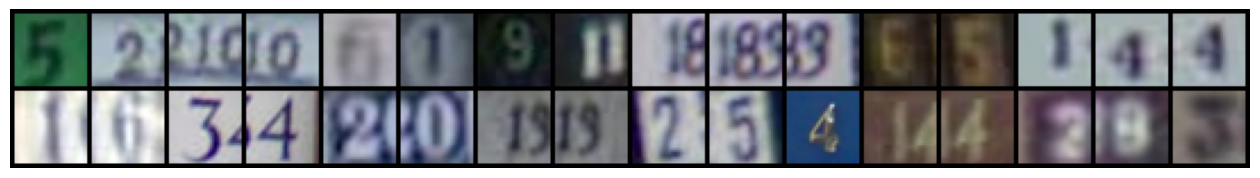

In [56]:
visualize(ResNet_test_loader)

Current Device: cuda
********************************************************************************
Now Training:: ResNet-18
********************************************************************************
Epoch:1	 Train_Loss: 2.0537	 Val_Loss: 1.9911	 Train_Acc: 0.2821	 Val_Acc: 0.3133	 Time: 11.28 seconds
Epoch:2	 Train_Loss: 1.9827	 Val_Loss: 1.9902	 Train_Acc: 0.3077	 Val_Acc: 0.3135	 Time: 11.22 seconds
Epoch:3	 Train_Loss: 1.9739	 Val_Loss: 1.9931	 Train_Acc: 0.3128	 Val_Acc: 0.3136	 Time: 11.25 seconds
Epoch:4	 Train_Loss: 1.9712	 Val_Loss: 1.9958	 Train_Acc: 0.3143	 Val_Acc: 0.3131	 Time: 11.28 seconds
Epoch:5	 Train_Loss: 1.9702	 Val_Loss: 1.9978	 Train_Acc: 0.3150	 Val_Acc: 0.3136	 Time: 11.25 seconds
Epoch:6	 Train_Loss: 1.9698	 Val_Loss: 1.9992	 Train_Acc: 0.3156	 Val_Acc: 0.3143	 Time: 11.13 seconds
Epoch:7	 Train_Loss: 1.9696	 Val_Loss: 2.0002	 Train_Acc: 0.3157	 Val_Acc: 0.3142	 Time: 11.15 seconds
Epoch:8	 Train_Loss: 1.9695	 Val_Loss: 2.0009	 Train_Acc: 0.3157	 Val_A

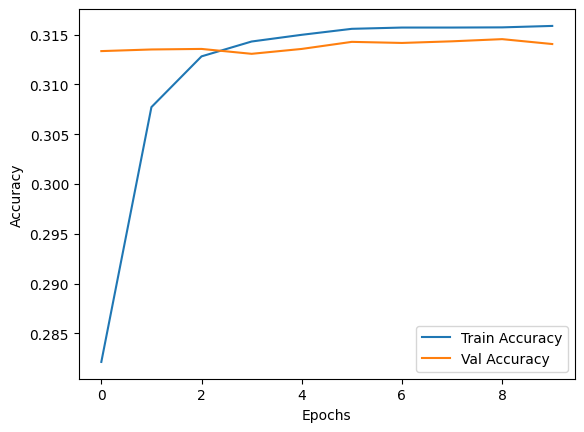

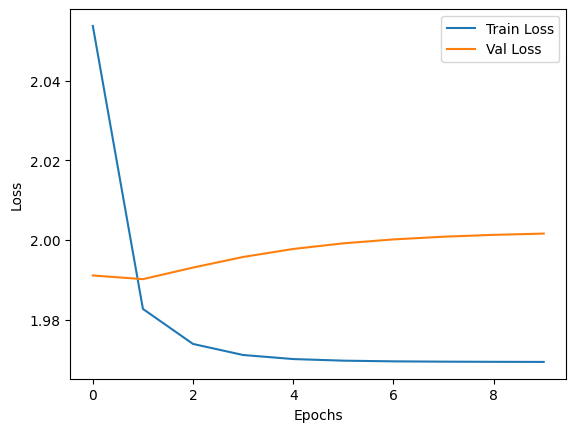

In [57]:
model_res = train_model(model_res, 'ResNet-18',
                        ResNet_train_loader, ResNet_val_loader)

Current Device: cuda
Classification Report:
              precision    recall  f1-score   support

           0       0.39      0.23      0.29      1744
           1       0.43      0.51      0.47      5099
           2       0.30      0.35      0.33      4149
           3       0.21      0.18      0.20      2882
           4       0.22      0.40      0.29      2523
           5       0.23      0.21      0.22      2384
           6       0.24      0.20      0.21      1977
           7       0.43      0.18      0.26      2019
           8       0.24      0.22      0.23      1660
           9       0.33      0.19      0.24      1595

    accuracy                           0.31     26032
   macro avg       0.30      0.27      0.27     26032
weighted avg       0.31      0.31      0.30     26032

Confusion Matrix:


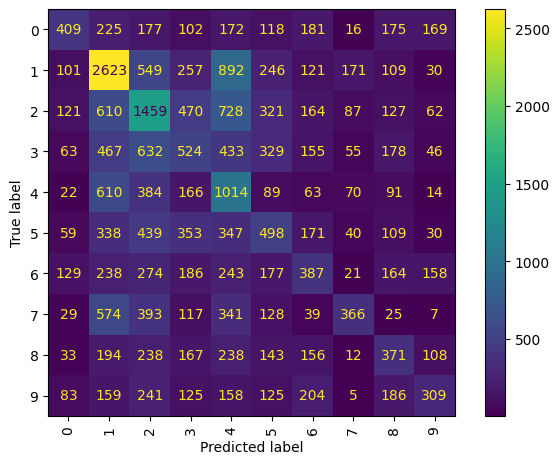

In [58]:
evaluate_model(model_res, 'ResNet-18', ResNet_test_loader)